<a href="https://colab.research.google.com/github/golfwhiper28/nida_is/blob/main/code/Regression_V2_LGB_MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prepare the enviorment

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6c27c4fe-2d76-1fa5-367c-2399f2569152)


In [ ]:
import sys
print(f"Python{sys.version}\n")

import numpy as np
print(f"Numpy{np.__version__}\n")

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print(f"TensorFlow{tf.__version__}\n")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")

#Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print(f"TendorFlow detected {len(gpus)} GPU(s):")
for i,gpu in enumerate(gpus):
  print(f"...GPU No. {i}: Name = {gpu.name}, Type ={gpu.device_type}")

Python3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

Numpy1.21.6

TensorFlow2.8.2

tf.keras.backend.image_data_format() = channels_last
TendorFlow detected 1 GPU(s):
...GPU No. 0: Name = /physical_device:GPU:0, Type =GPU


#Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys,os,time,datetime
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import Sequential
from sklearn import preprocessing
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D,GRU
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix,classification_report
from google.colab import drive
import seaborn as sns
import lightgbm as lgb
from traitlets.traitlets import Tuple

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Define Functions

In [ ]:
def loaddata():
  path = "/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/BTCUSDT_Hourly.csv"
  df_trans = pd.read_csv(path)
  df_trans[['open_date', 'open_times']] = df_trans['open_time'].str.split(' ', 1, expand=True)
  df_trans[['close_date', 'close_times']] = df_trans['close_time'].str.split(' ', 1, expand=True)
  df_trans["open_date"] = pd.to_datetime(df_trans["open_date"],format='%Y-%m-%d')
  df_trans["close_date"] = pd.to_datetime(df_trans["close_date"],format='%Y-%m-%d')
  df_trans["open_times"] = pd.to_datetime(df_trans["open_times"],format='%H:%M:%S').dt.time
  df_trans["close_times"] = pd.to_datetime(df_trans["close_times"],format='%H:%M:%S').dt.time
  df_trans["open_time"] = pd.to_datetime(df_trans['open_time'], format='%Y-%m-%d %H:%M:%S')
  df_trans["close_time"] = pd.to_datetime(df_trans['close_time'], format='%Y-%m-%d %H:%M:%S')
  df_trans = df_trans.sort_values(by='open_time').reset_index(drop=True)
  return df_trans

In [ ]:
# Split close price and return
def window_return(val, window):
  lst_x = []
  lst_y = []
  lst_x_return = []
  lst_y_return = []
  for i in range(0,len(val) - window -1,1):
    first_price = val[i]
    lst_x.append(val[i:i+window])
    lst_y.append(val[i+window])
    lst_x_return.append((val[i+1:i+window]-first_price)/first_price)
    lst_y_return.append((val[i+window]-first_price)/first_price)
  array_x_return = np.array(lst_x_return).reshape(-1,window-1)
  array_y_return = np.array(lst_y_return).reshape(-1,1)
  array_x = np.array(lst_x).reshape(-1,window)
  array_y = np.array(lst_y).reshape(-1,1)
  return array_x,array_x_return,array_y,array_y_return

In [ ]:
def split(x_array, y_array, ratio_train=0.8, ratio_test=0.1):
  n_data = x_array.shape[0]
  n_train = int(n_data * ratio_train)    
  n_test = int(n_data *ratio_test)       
  n_val = n_data -n_train -n_test

  x_train, y_train = x_array[:n_train], y_array[:n_train] 
  x_val, y_val      = x_array[n_train:n_train+n_val], y_array[n_train:n_train+n_val]
  x_test, y_test   = x_array[n_train+n_val:], y_array[n_train+n_val:]
  return [x_train, x_val, x_test], [y_train, y_val, y_test]

In [ ]:
def norm_val(norm_fn, lst_x, lst_y):
  return_x = [i for i in lst_x ]
  return_y = [i for i in lst_y ]
  for i in range(len(lst_x)):
    return_x[i] = norm_fn.transform(lst_x[i].reshape(-1,1)).reshape(lst_x[i].shape)
    return_y[i] = norm_fn.transform(lst_y[i].reshape(-1,1)).reshape(lst_y[i].shape)
  return return_x, return_y

#EDA

In [ ]:
df_trans = loaddata()
df_trans = df_trans[df_trans["open_date"]>="2020-12-01"][["symbol","open_time","close_price","volume","Number_of_trades"]]
df_trans['return'] = df_trans['close_price'].pct_change()
df_trans['return'] = df_trans['return'].fillna(0)
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12351 entries, 2674 to 15024
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   symbol            12351 non-null  object        
 1   open_time         12351 non-null  datetime64[ns]
 2   close_price       12351 non-null  float64       
 3   volume            12351 non-null  float64       
 4   Number_of_trades  12351 non-null  int64         
 5   return            12351 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 675.4+ KB


In [ ]:
df_trans.head()

,symbol,open_time,close_price,volume,Number_of_trades,return
2674,SOLUSDT,2020-12-01 00:00:00,1.9768,37873.34,543,0.000000
2675,SOLUSDT,2020-12-01 01:00:00,1.9715,38888.52,512,-0.002681
2676,SOLUSDT,2020-12-01 02:00:00,1.9680,43257.60,539,-0.001775
2677,SOLUSDT,2020-12-01 03:00:00,1.9699,45466.77,677,0.000965
2678,SOLUSDT,2020-12-01 04:00:00,1.9667,14399.31,427,-0.001624


In [ ]:
#df_trans.describe(include='all',datetime_is_numeric=True)
stats = df_trans[['close_price', 'volume', 'Number_of_trades', 'return']].describe()
stats.loc['var'] = df_trans[['close_price', 'volume', 'Number_of_trades', 'return']].var().tolist()
stats.loc['skew'] = df_trans[['close_price', 'volume', 'Number_of_trades', 'return']].skew().tolist()
stats.loc['kurt'] = df_trans[['close_price', 'volume', 'Number_of_trades', 'return']].kurtosis().tolist()
print(stats)

        close_price        volume  Number_of_trades        return
count  12351.000000  1.235100e+04      1.235100e+04  12351.000000
mean      81.756901  1.828378e+05      2.098921e+04      0.000458
std       69.737575  2.220529e+05      3.164980e+04      0.017066
min        1.183200  0.000000e+00      0.000000e+00     -0.192840
25%       24.212550  6.830495e+04      5.167500e+03     -0.007768
50%       54.459000  1.161924e+05      1.167600e+04      0.000000
75%      139.170000  2.108886e+05      2.455950e+04      0.007850
max      258.440000  4.974114e+06      5.859190e+05      0.186463
var     4863.329337  4.930748e+10      1.001710e+09      0.000291
skew       0.612993  5.744273e+00      5.544987e+00      0.548763
kurt      -0.844297  6.505483e+01      5.169817e+01     10.436257


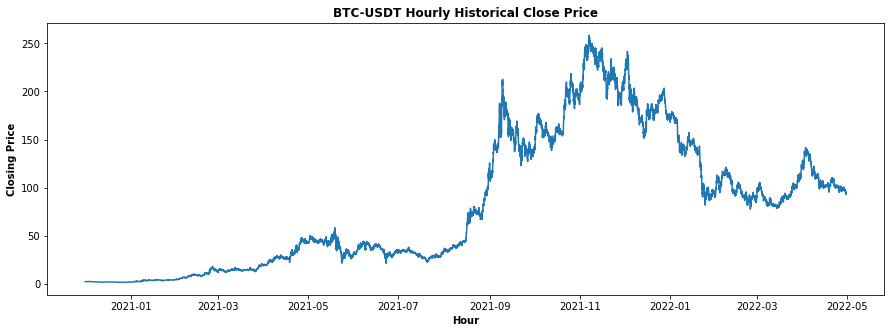

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(df_trans['open_time'],df_trans['close_price'])
plt.title('BTC-USDT Hourly Historical Close Price', fontweight="bold")
plt.xlabel('Hour', fontweight="bold")
plt.ylabel('Closing Price', fontweight="bold")
plt.show()

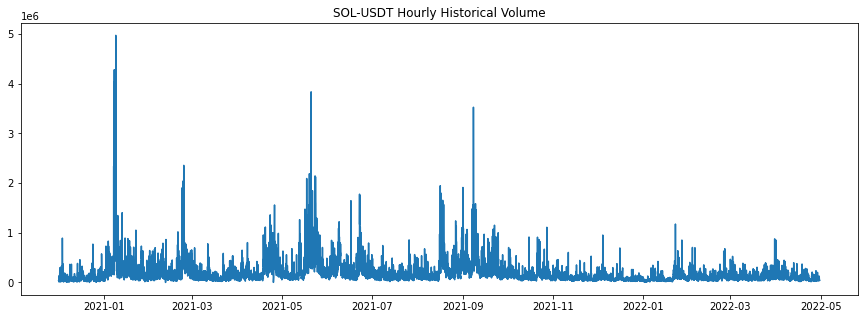

In [ ]:
plt.figure(figsize = (15,5))
# plt.plot(range(df_trans.shape[0]),df_trans['volume'])
plt.plot(df_trans['open_time'],df_trans['volume'])
plt.title('SOL-USDT Hourly Historical Volume')
plt.show()

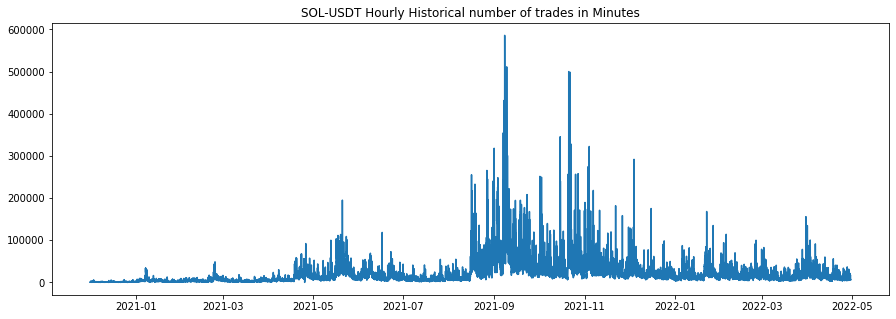

In [ ]:
plt.figure(figsize = (15,5))
# plt.plot(range(df_trans.shape[0]),df_trans['volume'])
plt.plot(df_trans['open_time'],df_trans['Number_of_trades'])
plt.title('SOL-USDT Hourly Historical number of trades in Minutes')
plt.show()

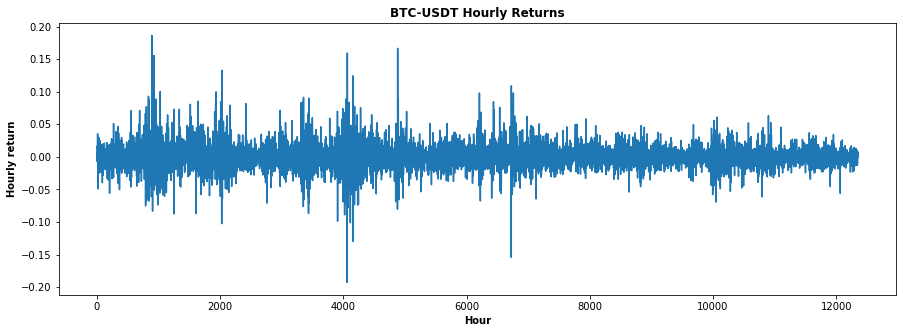

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(range(df_trans.shape[0]),df_trans['return'])
plt.title('BTC-USDT Hourly Returns', fontweight="bold")
plt.xlabel('Hour', fontweight="bold")
plt.ylabel('Hourly return', fontweight="bold")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


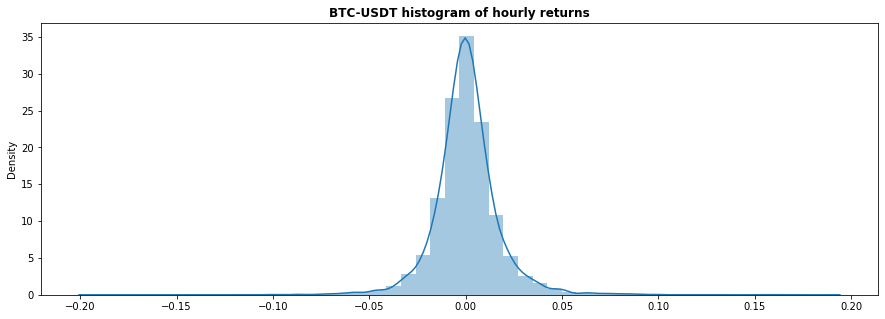

In [ ]:
plt.figure(figsize = (15,5))
his = df_trans[["open_time","return"]].set_index("open_time")
sns.distplot(his);
# plt.plot(df_trans[["close_time","return"]]['return'].hist(bins=50))
plt.title('BTC-USDT histogram of hourly returns', fontweight="bold")
plt.show()

#Preprocess

In [ ]:
#Create Sequence feature
window_size=4
x_close,x_return,y_close,y_return = window_return(df_trans["close_price"].values, window_size)
print(f"x_close.shape : {x_close.shape}")
print(f"x_return.shape : {x_return.shape}")
print(f"y_close.shape : {y_close.shape}")
print(f"y_return.shape : {y_return.shape}")

x_close.shape : (12346, 4)
x_return.shape : (12346, 3)
y_close.shape : (12346, 1)
y_return.shape : (12346, 1)


In [ ]:
# Split data tuples x-(train, val, test), y-(train, val, test)
lst_x_close ,lst_y_close = split(x_close, y_close, 0.8, 0.1)
lst_x_return ,lst_y_return = split(x_return, y_return, 0.8, 0.1)

In [ ]:
print(f"Shape Price:{lst_x_close[0].shape} ,Val:{lst_x_close[1].shape}, Test:{lst_x_close[2].shape}")
print(f"Shape Return:{lst_x_return[0].shape} ,Val:{lst_x_return[1].shape}, Test:{lst_x_return[2].shape}")

Shape Price:(9876, 4) ,Val:(1236, 4), Test:(1234, 4)
Shape Return:(9876, 3) ,Val:(1236, 3), Test:(1234, 3)


In [ ]:
print(f"Shape Price:{lst_y_close[0].shape} ,Val:{lst_y_close[1].shape}, Test:{lst_y_close[2].shape}")
print(f"Shape Return:{lst_y_return[0].shape} ,Val:{lst_y_return[1].shape}, Test:{lst_y_return[2].shape}")

Shape Price:(9876, 1) ,Val:(1236, 1), Test:(1234, 1)
Shape Return:(9876, 1) ,Val:(1236, 1), Test:(1234, 1)


In [ ]:
#Normalize Data form train data set
#Fit Normalize tools
min_max_scaler = MinMaxScaler().fit(lst_x_return[0].reshape(-1,1))
lst_x_norm   ,lst_y_norm= norm_val(min_max_scaler, lst_x_return, lst_y_return)
print(f"Shape x:{lst_x_norm[0].shape} ,Val:{lst_x_norm[1].shape}, Test:{lst_x_norm[2].shape}")
print(f"Shape y:{lst_y_norm[0].shape} ,Val:{lst_y_norm[1].shape}, Test:{lst_y_norm[2].shape}")

Shape x:(9876, 3) ,Val:(1236, 3), Test:(1234, 3)
Shape y:(9876, 1) ,Val:(1236, 1), Test:(1234, 1)


In [ ]:
#Create data train - validate - test ( Size , Time , Feature)
#Create x array
x_train_norm = lst_x_norm[0]
x_val_norm   = lst_x_norm[1]
x_test_norm  = lst_x_norm[2]

#Create y array
y_train_norm = lst_y_norm[0]
y_val_norm   = lst_y_norm[1]
y_test_norm  = lst_y_norm[2]
y_test = lst_y_close[2]

print(f"\n x_train_norm.shape {x_train_norm.shape}{y_train_norm.shape} \n{x_train_norm[0]} -->y= {y_train_norm[0]}")
print(f"\n x_val_norm.shape {x_val_norm.shape}{y_val_norm.shape} \n{x_val_norm[0]} -->y={y_val_norm[0]}")
print(f"\n x_test_norm.shape {x_test_norm.shape}{y_test_norm.shape}\n{x_test_norm[0]} -->y={y_test_norm[0]}")


 x_train_norm.shape (9876, 3)(9876, 1) 
[0.42729119 0.44342365 0.47781528] -->y= [0.4666586]

 x_val_norm.shape (1236, 3)(1236, 1) 
[0.45884285 0.44331051 0.44356258] -->y=[0.44567469]

 x_test_norm.shape (1234, 3)(1234, 1)
[0.46339077 0.44250137 0.43852559] -->y=[0.46841221]


In [ ]:
len(lst_x_norm)

3

In [ ]:
lst_x_norm

[array([[0.42729119, 0.44342365, 0.47781528],
        [0.48534053, 0.52012282, 0.50883941],
        [0.50365506, 0.49242097, 0.51532901],
        ...,
        [0.48674425, 0.47997647, 0.50071365],
        [0.46228916, 0.48292791, 0.47270784],
        [0.48970105, 0.47946242, 0.46384365]]),
 array([[0.45884285, 0.44331051, 0.44356258],
        [0.4534498 , 0.45370257, 0.45582047],
        [0.46927865, 0.47140547, 0.44791081],
        ...,
        [0.49232791, 0.48847977, 0.50677442],
        [0.46520067, 0.48338129, 0.47772547],
        [0.48722418, 0.48156253, 0.46057082]]),
 array([[0.46339077, 0.44250137, 0.43852559],
        [0.44810371, 0.44412188, 0.47405389],
        [0.46502045, 0.49512194, 0.52280592],
        ...,
        [0.4594927 , 0.43914859, 0.46154374],
        [0.44862839, 0.47108114, 0.47066756],
        [0.4916015 , 0.49118564, 0.49588515]])]

In [ ]:
x_train_norm

array([[0.42729119, 0.44342365, 0.47781528],
       [0.48534053, 0.52012282, 0.50883941],
       [0.50365506, 0.49242097, 0.51532901],
       ...,
       [0.48674425, 0.47997647, 0.50071365],
       [0.46228916, 0.48292791, 0.47270784],
       [0.48970105, 0.47946242, 0.46384365]])

In [ ]:
#Convert to float32
x_train_norm = x_train_norm.astype(np.float32)
y_train_norm = y_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

#Create Model

In [ ]:
#Prepare Model
dtrain = lgb.Dataset(x_train_norm, label=y_train_norm.ravel() )
dvalidate = lgb.Dataset(x_val_norm, label=y_val_norm.ravel() )

In [ ]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric':'l2',
          'num_leaves':10,
          'max_depth':5,
          'drop_rate ':0.3,
          'reg_sqrt':True,
          'boost_from_average':True,
          'learning_rate': 0.0001,
          'verbose': 0,
         }

In [ ]:
#Run Model
start_tm = time.time()
evals_results = {}
model_lgbm = lgb.train(params, 
                  train_set =dtrain, 
                  valid_sets=dvalidate,
                  evals_result=evals_results, 
                  num_boost_round=1000, #iterations
                  early_stopping_rounds=100,
                  verbose_eval=50, 
                  feval=None)
print(f">>>>> Training Time >>>> {time.time() - start_tm} seconds")

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 0.00368115
[100]	valid_0's l2: 0.0036534
[150]	valid_0's l2: 0.00362592
[200]	valid_0's l2: 0.00359873
[250]	valid_0's l2: 0.00357181
[300]	valid_0's l2: 0.00354517
[350]	valid_0's l2: 0.0035188
[400]	valid_0's l2: 0.00349273
[450]	valid_0's l2: 0.0034669
[500]	valid_0's l2: 0.00344132
[550]	valid_0's l2: 0.003416
[600]	valid_0's l2: 0.00339094
[650]	valid_0's l2: 0.00336613
[700]	valid_0's l2: 0.00334162
[750]	valid_0's l2: 0.00331734
[800]	valid_0's l2: 0.00329331
[850]	valid_0's l2: 0.00326952
[900]	valid_0's l2: 0.00324596
[950]	valid_0's l2: 0.00322265
[1000]	valid_0's l2: 0.00319959
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00319959
>>>>> Training Time >>>> 0.642014741897583 seconds


#Evaluate model

In [ ]:
lgbm_preds_norm = model_lgbm.predict(x_test_norm).reshape(-1, 1)
lgbm_preds = min_max_scaler.inverse_transform(lgbm_preds_norm)
lgbm_price = (lst_x_close[2][:,0].reshape(-1,1)*(1+lgbm_preds)) # Return --> Price from P-20 x (1+return)
true_price = lst_y_close[2]

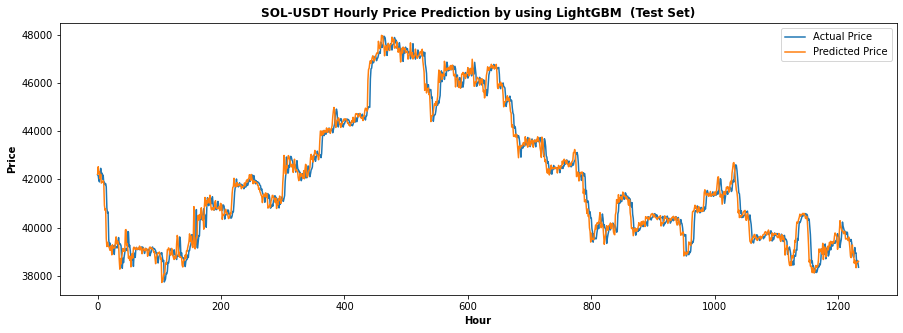

In [ ]:
#Plot training and validation loss values
plt.figure(figsize=(15,5))
plt.plot( lgbm_price)
plt.plot( true_price)
plt.title('SOL-USDT Hourly Price Prediction by using LightGBM  (Test Set)', fontweight="bold")
plt.ylabel('Price', fontweight="bold")
plt.xlabel('Hour', fontweight="bold")
plt.legend(['Actual Price','Predicted Price'], loc='upper right')

plt.show()

In [ ]:
mse  = mean_squared_error(true_price,lgbm_price)
mae  = mean_absolute_error(true_price,lgbm_price)

print(f"mean_squared_error : {mse}")
print(f"mean_absolute_error : {mae}")

mean_squared_error : 170018.60254832354
mean_absolute_error : 285.3655916639615


In [ ]:
rmse = np.sqrt(np.mean(((lgbm_price - true_price) ** 2)))
rmse

412.3331208480875

In [ ]:
move_avg = lst_x_close[2].mean(axis=1).reshape(-1, 1)
mse  = mean_squared_error(true_price,move_avg)
mae  = mean_absolute_error(true_price,move_avg)
print(f"mean_squared_error : {mse}")
print(f"mean_absolute_error : {mae}")

mean_squared_error : 92577.68009547702
mean_absolute_error : 205.95418760129647


In [ ]:
rmse = np.sqrt(np.mean(((move_avg - true_price) ** 2)))
rmse

304.265805005224

In [ ]:
lst_x_close[2]

array([[42215.67, 42151.66, 41914.33, 41869.16],
       [42151.66, 41914.33, 41869.16, 42208.71],
       [41914.33, 41869.16, 42208.71, 42520.99],
       ...,
       [38642.24, 38543.11, 38331.54, 38564.44],
       [38543.11, 38331.54, 38564.44, 38560.15],
       [38331.54, 38564.44, 38560.15, 38608.63]])

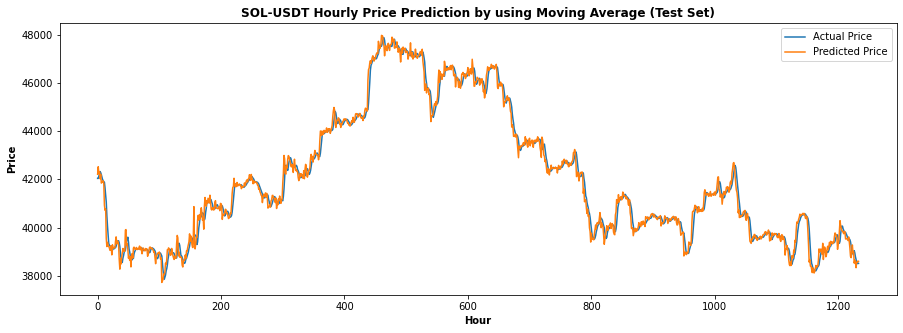

In [ ]:
#Plot training and validation loss values
plt.figure(figsize=(15,5))
plt.plot( move_avg)
plt.plot( true_price)
plt.title('SOL-USDT Hourly Price Prediction by using Moving Average (Test Set)', fontweight="bold")
plt.ylabel('Price', fontweight="bold")
plt.xlabel('Hour', fontweight="bold")
plt.legend(['Actual Price','Predicted Price'], loc='upper right')

plt.show()

In [ ]:
lst_x_close[2].mean(axis=1)

array([42037.705 , 42035.965 , 42128.2975, ..., 38520.3325, 38499.81  ,
       38516.19  ])

In [ ]:
lst_x_close[2].mean(axis=1).reshape(-1, 1)

array([[42037.705 ],
       [42035.965 ],
       [42128.2975],
       ...,
       [38520.3325],
       [38499.81  ],
       [38516.19  ]])

In [ ]:
pd.set_option('display.max_rows', 500)

result = pd.DataFrame({"price_t20":lst_x_close[2][:,-1].ravel()
              ,"true_price_t21":true_price.ravel()
              ,"lgbm_price":lgbm_price.ravel()
              ,"move_avg":move_avg.ravel()})
result

,price_t20,true_price_t21,lgbm_price,move_avg
0,41869.16,42208.71,42184.781704,42037.7050
1,42208.71,42520.99,42148.913230,42035.9650
2,42520.99,42233.16,41960.045240,42128.2975
3,42233.16,42320.15,41892.335580,42208.0050
4,42320.15,42023.10,42205.959512,42320.7525
...,...,...,...,...
1229,38543.11,38331.54,38945.149770,38678.1350
1230,38331.54,38564.44,38494.144041,38509.8050
1231,38564.44,38560.15,38630.921611,38520.3325
1232,38560.15,38608.63,38540.598378,38499.8100


In [ ]:
result.to_excel (r'/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/lgbm_ma_result.xlsx', index = False, header=True)

In [ ]:
np.std(move_avg)/np.mean(move_avg)

0.0639800255307893

In [ ]:
np.std(lgbm_price)/np.mean(lgbm_price)

0.06401315241175788

#Investment Strategy

In [ ]:
pd.set_option('display.max_rows', 500)

result = pd.DataFrame({"price_t4":lst_x_close[2][:,-1].ravel()
              ,"true_price_t5":true_price.ravel()
              ,"lgbm_price":lgbm_price.ravel()
              ,"move_avg":move_avg.ravel()})
result.head()

,price_t4,true_price_t5,lgbm_price,move_avg
0,41869.16,42208.71,42184.781704,42037.7050
1,42208.71,42520.99,42148.913230,42035.9650
2,42520.99,42233.16,41960.045240,42128.2975
3,42233.16,42320.15,41892.335580,42208.0050
4,42320.15,42023.10,42205.959512,42320.7525


In [ ]:
result.to_excel (r'/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/lgbm_ma_BTC_result.xlsx', index = False, header=True)

In [ ]:
result[result["price_t4"]==87.71]

,price_t4,true_price_t5,lgbm_price,move_avg


In [ ]:
budget=1000
sol=0
budget_hist=[budget]
btcs_hist=[sol]
stopper=0.15
fee = 0.001
temp_buy_price=0
cost=0
for i in range(len(result)):
  print("---------------------------")
  if (result["price_t4"][i]<result["lgbm_price"][i]) and (sol<=0):
    print("BUY: ", i)
    sol = budget/((1+fee)*result["price_t4"][i])
    budget = budget - (sol*((1+fee)*result["price_t4"][i]))
    budget=0
    temp_buy_price=result["price_t4"][i]
    cost=(sol*((1+fee)*result["price_t4"][i]))
    print("SOL buy price: ", result["price_t4"][i])
    print("SOL: ", sol)
    print("budget: ", budget)
    print("cost: ", (sol*((1+fee)*result["price_t4"][i])))
  elif (result["price_t4"][i]>result["lgbm_price"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
    if (result["price_t4"][i]>(temp_buy_price)):
      print("SELL (Case 1): ", i)
      budget = budget + (sol*((1-fee)*result["price_t4"][i]))
      print("SOL sell price: ", result["price_t4"][i])
      print("SOL: ", sol)
      print("Stopper value: ", (cost*(1-stopper)))
      print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
      sol = 0
    elif (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))):
      print("SELL (Case 2): ", i)
      print("SOL buy price: ", temp_buy_price)
      print("SOL sell price: ", result["price_t4"][i])
      print("Stopper value: ", (cost*(1-stopper)))
      print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
      budget = budget + (sol*((1-fee)*result["price_t4"][i]))
      sol = 0
    # else:
    #   print("SELL: ", i)
    #   budget = budget + (sol*((1-fee)*result["price_t4"][i]))
    #   print("SOL sell price: ", result["price_t4"][i])
    #   print("SOL: ", sol)
    #   print("Stopper value: ", (cost*(1-stopper)))
    #   print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
    #   sol = 0


  budget_hist=budget_hist+[budget]
  btcs_hist=btcs_hist+[sol]

---------------------------
BUY:  0
SOL buy price:  86.86
SOL:  11.501277906988248
budget:  0
cost:  1000.0000000000001
---------------------------
---------------------------
SELL (Case 1):  2
SOL sell price:  88.91
SOL:  11.501277906988248
Stopper value:  850.0000000000001
revenue:  1021.5560400916148
---------------------------
---------------------------
---------------------------
BUY:  5
SOL buy price:  87.03
SOL:  11.726249621820383
budget:  0
cost:  1021.5560400916148
---------------------------
---------------------------
---------------------------
---------------------------
SELL (Case 1):  9
SOL sell price:  87.87
SOL:  11.726249621820383
Stopper value:  868.3226340778725
revenue:  1029.3551687150878
---------------------------
---------------------------
---------------------------
BUY:  12
SOL buy price:  86.2
SOL:  11.929545729387641
budget:  0
cost:  1029.3551687150878
---------------------------
---------------------------
---------------------------
------------------

Text(0.5, 0, 'Hour')

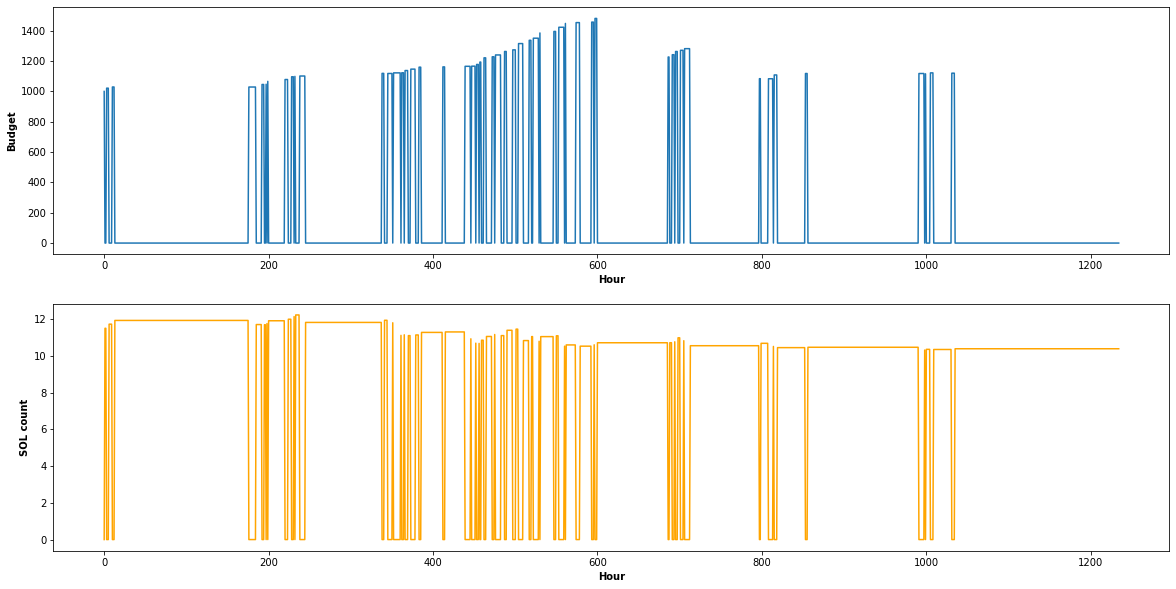

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(20,10))
ax1.plot(budget_hist)
ax1.set_ylabel("Budget", fontweight="bold")
ax1.set_xlabel("Hour", fontweight="bold")

ax2.plot(btcs_hist,color="orange")
ax2.set_ylabel("SOL count", fontweight="bold")
ax2.set_xlabel("Hour", fontweight="bold")

In [ ]:
result.head()

,price_t4,true_price_t5,lgbm_price,move_avg
0,90.98,91.02,91.572679,91.4625
1,91.02,90.66,92.047690,91.3325
2,90.66,90.73,91.342597,90.9925
3,90.73,91.00,91.012479,90.8475
4,91.00,91.35,91.053848,90.8525


In [ ]:
budget=1000
sol=0
budget_hist=[budget]
btcs_hist=[sol]
stopper=0.15
fee = 0.001
temp_buy_price=0
cost=0
for i in range(len(result)):
  print("---------------------------")
  if (result["price_t4"][i]<result["move_avg"][i]) and (sol<=0):
    print("BUY: ", i)
    sol = budget/((1+fee)*result["price_t4"][i])
    budget = budget - (sol*((1+fee)*result["price_t4"][i]))
    budget=0
    temp_buy_price=result["price_t4"][i]
    cost=(sol*((1+fee)*result["price_t4"][i]))
    print("SOL buy price: ", result["price_t4"][i])
    print("SOL: ", sol)
    print("budget: ", budget)
    print("cost: ", (sol*((1+fee)*result["price_t4"][i])))
  elif (result["price_t4"][i]>result["move_avg"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
    if (result["price_t4"][i]>(temp_buy_price)):
      print("SELL (Case 1): ", i)
      budget = budget + (sol*((1-fee)*result["price_t4"][i]))
      print("SOL sell price: ", result["price_t4"][i])
      print("SOL: ", sol)
      print("Stopper value: ", (cost*(1-stopper)))
      print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
      sol = 0
    elif (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))):
      print("SELL (Case 2): ", i)
      print("SOL buy price: ", temp_buy_price)
      print("SOL sell price: ", result["price_t4"][i])
      print("Stopper value: ", (cost*(1-stopper)))
      print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
      budget = budget + (sol*((1-fee)*result["price_t4"][i]))
      sol = 0
    # else:
    #   print("SELL: ", i)
    #   budget = budget + (sol*((1-fee)*result["price_t4"][i]))
    #   print("SOL sell price: ", result["price_t4"][i])
    #   print("SOL: ", sol)
    #   print("Stopper value: ", (cost*(1-stopper)))
    #   print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
    #   sol = 0


  budget_hist=budget_hist+[budget]
  btcs_hist=btcs_hist+[sol]

---------------------------
BUY:  0
SOL buy price:  86.86
SOL:  11.501277906988248
budget:  0
cost:  1000.0000000000001
---------------------------
SELL (Case 1):  1
SOL sell price:  87.8
SOL:  11.501277906988248
Stopper value:  850.0000000000001
revenue:  1008.8023880333345
---------------------------
---------------------------
---------------------------
BUY:  4
SOL buy price:  88.3
SOL:  11.413302303962569
budget:  0
cost:  1008.8023880333345
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
-----------------

Text(0.5, 0, 'Hour')

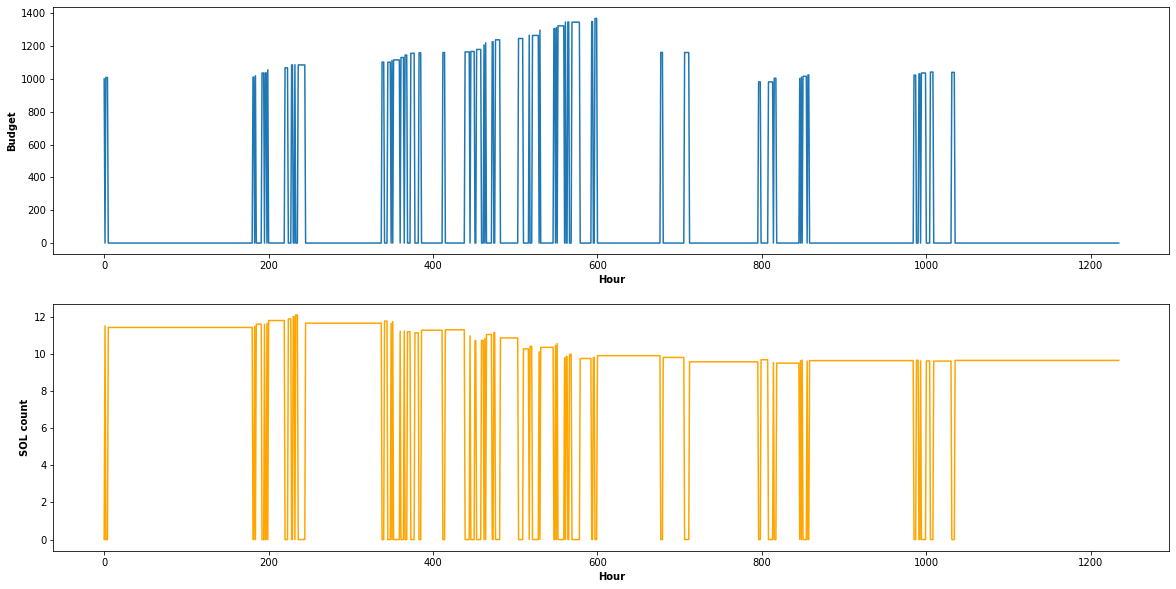

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(20,10))
ax1.plot(budget_hist)
ax1.set_ylabel("Budget", fontweight="bold")
ax1.set_xlabel("Hour", fontweight="bold")

ax2.plot(btcs_hist,color="orange")
ax2.set_ylabel("SOL count", fontweight="bold")
ax2.set_xlabel("Hour", fontweight="bold")